# T&P live demo at PyHEP 2021

## Initial spark setup

Make sure spark object is created.

Click on the 'star' symbol above to initiate a connection to CERN's `analytix` spark cluster (the spark configuration was already provided at the beginning of the `SWAN` session)

Upon successful connection an object `spark` is created.

In [2]:
spark

## Imports

Import system packages (including pyspark and matplotlib).

In [3]:
import os
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import AutoMinorLocator
from pyspark.sql import Column as col

if 'notebooks' in os.getcwd():
    os.chdir('..')

A nice trick for long-running computations.

In [4]:
# For playing a beep at the end of very long computations
from IPython.display import Audio
from IPython.core.display import display

def beep():
    sr = 22050 # sample rate
    T = 0.3    # seconds
    t = np.linspace(0, T, int(T*sr), endpoint=False) # time variable
    x = 0.5*np.sin(2*np.pi*440*t) # pure sine wave at 440 Hz
    display(Audio(x, rate=sr, autoplay=True))

In [5]:
beep()

Import package modules and configuration file.

The config file holds all the necessary information to perform a full T&P computation:

    1. List of efficiencies to compute
    2. List of numerator and denominator definitions
    3. List of binning variables
    4. List of systematic variations to attempt
    
In the notebook version, we only use some of that information (e.g., binning and definitions).

For this exploratory work, the efficiencies are defined here, and there are no systematics.

In [6]:
from flattener import *
from registry import registry
from config import Configuration
from notebook_helper_functions import *

my_config = Configuration('configs/pyhep_demo_cfg.json')

## Load spark dataframe and do some pre-processing

This is the core of the computation.

The parquet files are loaded by spark, and the definitions in the config are applied as additional columns in the dataframe.

Spark dataframes are very similar to pandas dataframes, except optimized for large scale processing.

Then the pre-selection is applied, which is common to all efficiencies.

Finally, weights are applied and the binning structure is created.

In [9]:
def get_df(resonance, era, subEra):
    
    doGen = subEra in ['DY_madgraph', 'JPsi_pythia8']
    
    # all data sources are defined in the registry
    fnames = list(registry.parquet(particle, probe, resonance, era, subEra))

    # default numerator/denominator defintions
    definitions = my_config.definitions()

    # get the dataframe
    print('Loading parquet files:', fnames)
    baseDF = spark.read.parquet(*fnames)
    
    # define additional columns specified in config and add to dataframe
    defDF = baseDF
    for d in definitions:
        defDF = defDF.withColumn(d, F.expr(definitions[d]))

    # apply pre-selection to tags and event
    preselDF = defDF.filter(my_config.selection())        
        
    # build the weights (genWeights + pileup for MC)
    weightedDF = get_weighted_dataframe(preselDF, doGen, resonance, era, subEra)
    
    # create the binning structure
    binningSet = create_binning_structure(my_config, subEra)
        
    # Created binned dataframe using binning structure
    binning = my_config.binning()
    variables = my_config.variables()
    binnedDF = weightedDF
    for bName in binningSet:
        binnedDF = get_binned_dataframe(binnedDF, bName+"Bin", variables[bName]['variable'], binning[bName])

    return binnedDF

Here we choose the particular T&P we want to perform:

    1. Which resonance
    2. Which kind of probe 
    3. Which data and simulation samples to run on
    
For this demo we use roughly half of 2018 data which corresponds to about 32 $\mathrm{fb^{-1}}$ of data, so quite a large dataset.

In [10]:
particle = 'muon'
probe = 'generalTracks'
resonance = 'Z'
era = 'Run2018'
data_subera = 'Run2018D' # about 2.7M tag-probe pairs (in 1.5M events)
mc_subera = 'DY_madgraph' # about 4.2M tag-probe pairs (in 2.3M events)
subEras = [data_subera, mc_subera]

dfs = {subEra: get_df(resonance,era,subEra) for subEra in subEras}

Loading parquet files: ['/cms/muon_pog/parquet/muon/Z/Run2018/AOD/Run2018D/tnp.parquet']
Loading parquet files: ['/cms/muon_pog/parquet/muon/Z/Run2018/AOD/DY_madgraph/tnp.parquet']


Any operations on a spark dataframe needs to be performed on the spark clusters.

## Check a few tag-and-probe plots

Now that we have the spark dataframes, we can check some distributions to make sure things look reasonable.

First let's check the dimuon invariant mass to make sure it's a nice peak around Z.

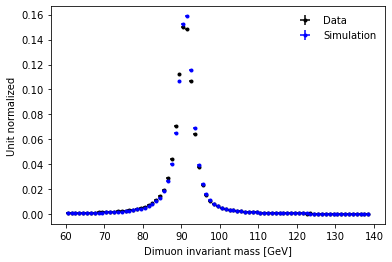

In [12]:
plot(dfs, 'pair_mass', np.array(np.arange(60, 140, 1)), subEras, xlabel=r'Dimuon invariant mass [GeV]')

## Compute passing and failing probes for a particular efficiency measurement

This step performs the actual flattening of the dataframe by checking which probes pass or fail the numerator selection.

The official production fits the pass and fail spectra instead to extract the number of pass and fail signal events only.

In [13]:
def get_pass_fail(df, num, den, binVars):
    
    # First apply the denominator selection to the dataframe (e.g. TrackerMuons)
    reducedDF = df.filter(df[den]==True)
    
    # This actually counts how many pre-selected probes pass the numerator ('pass') criterion, for each unique bin
    reducedDF = reducedDF.groupBy(num, *[b+'Bin' for b in list(binVars)+['mass']])
    reducedDF = reducedDF.agg({'weight': 'sum', 'weight2': 'sum'})
    reducedDF = reducedDF.withColumnRenamed('sum(weight)', 'sumw')
    reducedDF = reducedDF.withColumnRenamed('sum(weight2)', 'sumw2')

    # for simple cut and count just cut on the 70--110 GeV dimuon invariant mass range and then re-count
    narrowWindow = reducedDF.filter('massBin >= 40 and massBin <= 200')
    countsDF = narrowWindow.groupby([num] + [b+'Bin' for b in list(binVars)]).agg({'sumw': 'sum', 'sumw2': 'sum'})
    countsDF = countsDF.withColumnRenamed('sum(sumw)','sumw')
    countsDF = countsDF.withColumnRenamed('sum(sumw2)','sumw2')
    
    # Convert processed spark dataframe to pandas
    realized = countsDF.toPandas()
    
    # complete any missing rows with 0's
    cols=[num, *[b+'Bin' for b in list(binVars)]]
    vals=[realized[col].unique() for col in cols]
    mi = pd.MultiIndex.from_product(vals, names=cols)
    realized = realized.set_index(cols).reindex(mi, fill_value=0).reset_index()

    return realized

In [15]:
num, den = 'TightID', 'TrackerMuons'
bins = ['eta']

realized_eta = {subEra: get_pass_fail(dfs[subEra], num, den, bins) for subEra in subEras}

beep()

## Compute and plot efficiencies

Now we just need to extract how many probes pass or fail the numerator selection for each bin, and compute & plot the efficiency.

To compute the cut-and-count efficiency, the number of 'pass' probes is divided by the sum of 'pass' and 'fail' probes.

In [16]:
def get_eff(df,binVars):
    '''return a df with keys eff, eff_err, ... '''
    
    df_num = df[df[num]==True].set_index([b+'Bin' for b in binVars]).sort_index()
    df_den = df[df[num]==False].set_index([b+'Bin' for b in binVars]).sort_index()
    
    df_num['eff'] = df_num['sumw'] / (df_den['sumw'] + df_num['sumw'])
    
    # TODO binomial with w!=1
    p = df_num['sumw']
    f = df_den['sumw']
    N = p+f
    df_num['eff_err'] = 1/N * np.sqrt(p*(1-p/N))
    
    return df_num[['eff','eff_err']]

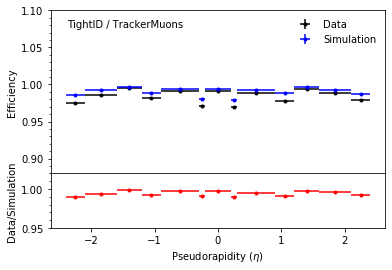

In [17]:
df_eff = {subEra: get_eff(realized_eta[subEra], bins) for subEra in subEras}

reduced_eff = {subEra: df_eff[subEra] for subEra in subEras}

plot_eff(reduced_eff, num, den, my_config, 'eta', subEras, xlabel=r'Pseudorapidity ($\eta$)')

We can derive N-dimensional scale factors too:

In [18]:
num, den = 'LooseID', 'TrackerMuons'
bins = ['abseta', 'pt']

realized_abseta_pt = {subEra: get_pass_fail(dfs[subEra], num, den, bins) for subEra in subEras}

beep()

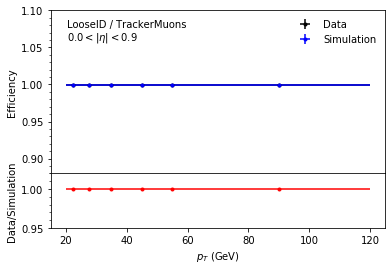

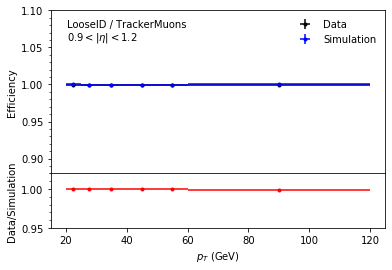

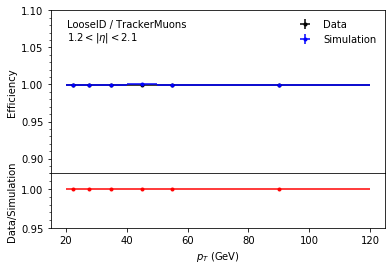

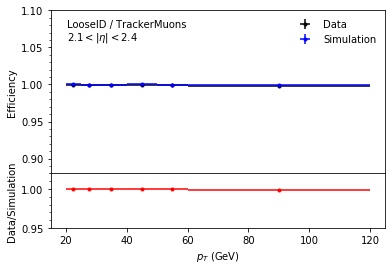

In [19]:
df_eff = {subEra: get_eff(realized_abseta_pt[subEra], bins) for subEra in subEras}

for absetaBin in range(1,5):
    
    reduced_eff = {subEra: df_eff[subEra].loc[pd.IndexSlice[absetaBin,:]] for subEra in subEras}
    
    bz = my_config.binning()['abseta']
    additional_text = r'${low} < |\eta| < {high}$'.format(low=bz[absetaBin-1], high=bz[absetaBin])
    
    plot_eff(reduced_eff, num, den, my_config, 'pt', subEras, xlabel=r'$p_{T}$ (GeV)', additional_text=additional_text)

Essentially any variable in the ntuple can be used to bin the efficiencies, if defined in the config.

In [20]:
num, den = 'TightID', 'TrackerMuons'
bins = ['nvtx']

realized_nvtx = {subEra: get_pass_fail(dfs[subEra], num, den, bins) for subEra in subEras}

beep()

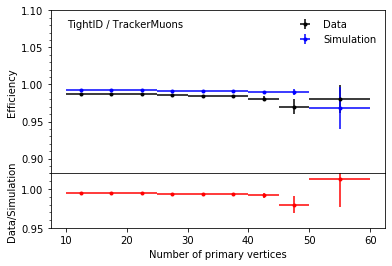

In [21]:
df_eff = {subEra: get_eff(realized_nvtx[subEra], bins) for subEra in subEras}

reduced_eff = {subEra: df_eff[subEra] for subEra in subEras}

plot_eff(reduced_eff, num, den, my_config, 'nvtx', subEras, xlabel=r'Number of primary vertices')